In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.gridspec import GridSpec
import scipy.linalg as la
import math
from tabulate import tabulate

import matplotlib.animation as animation
import imageio.v2 as imageio
import os

C:\Users\vkuzniet\AppData\Local\Temp\ipykernel_46888\2816481819.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 256)


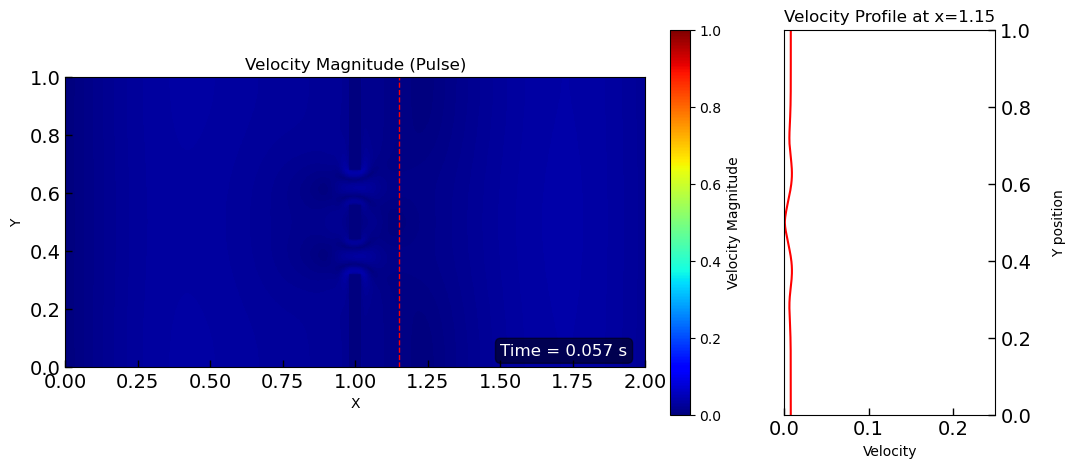

In [3]:
#Simulation Parameters
nx, ny = 400, 200
Lx, Ly = 2.0, 1.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
nt = 500
nit = 50
nu = 0.05
dt = min(dx, dy)**2 / (4 * nu)

U0 = 1.0  #Amplitude 

y = np.linspace(0, Ly, ny)
x = np.linspace(0, Lx, nx)
X, Y = np.meshgrid(x, y)

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

#Double-Slit Obstacle
screen_start = int(nx * 0.49)  
screen_end = int(nx * 0.51)
slit_width = 25
slit_distance = 25

mid_y = ny // 2
top_slit_center = mid_y + slit_distance // 2 + slit_width // 2
bottom_slit_center = mid_y - slit_distance // 2 - slit_width // 2
top_slit_range = (top_slit_center - slit_width // 2, top_slit_center + slit_width // 2)
bottom_slit_range = (bottom_slit_center - slit_width // 2, bottom_slit_center + slit_width // 2)

obstacle_mask = np.zeros((ny, nx), dtype=bool)
for xi in range(screen_start, screen_end):
    for yi in range(ny):
        if not (top_slit_range[0] <= yi < top_slit_range[1]) and not (bottom_slit_range[0] <= yi < bottom_slit_range[1]):
            obstacle_mask[yi, xi] = True

def apply_obstacle(u, v):
    u[obstacle_mask] = 0
    v[obstacle_mask] = 0
    return u, v

#Time step
current_time = 0.0
def step(u, v, p, b):
    global current_time
    un = u.copy()
    vn = v.copy()

    b[1:-1, 1:-1] = (1 / dt) * (
        (un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx) +
        (vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy)
    ) - (
        ((un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx))**2 +
        2 * ((un[2:, 1:-1] - un[0:-2, 1:-1]) / (2 * dy) *
             (vn[1:-1, 2:] - vn[1:-1, 0:-2]) / (2 * dx)) +
        ((vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy))**2
    )

    #Jacoby iterations
    for _ in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) -
                         b[1:-1, 1:-1] * dx**2 * dy**2) / (2 * (dx**2 + dy**2))
        p[:, -1] = p[:, -2]
        p[:, 0] = p[:, 1]
        p[0, :] = p[1, :]
        p[-1, :] = p[-2, :]

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))

    #Pulse
    if 0.0 <= current_time <= 12*dt:
        u[:, 0] = U0
    else:
        u[:, 0] = 0

    v[:, 0] = 0

    #Boundary conditions
    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]
    u[0, :] = u[1, :]
    u[-1, :] = u[-2, :]
    v[0, :] = 0
    v[-1, :] = 0

    u, v = apply_obstacle(u, v)
    current_time += dt
    return u, v, p, b

#Animation
vmin, vmax = 0, 1.
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})
ax1, ax2 = axes
ax1.tick_params(direction='in', length=5, width=1, labelsize=14)
ax2.tick_params(direction='in', length=5, width=1, labelsize=14, labelright=True, right=True)

cmap = plt.cm.get_cmap('jet', 256)
vel_mag = np.sqrt(u**2 + v**2)
cax1 = ax1.imshow(vel_mag, extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap,
                  vmin=vmin, vmax=vmax, aspect='equal', animated=True)
ax1.set_title("Velocity Magnitude (Pulse)")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
cbar = fig.colorbar(cax1, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label("Velocity Magnitude")

ax1.axvline(x=1.15, color='red', linestyle='--', lw=1)

ax2.set_title("Velocity Profile at x=1.15")
ax2.set_ylabel("Y position", labelpad=15)
ax2.set_xlabel("Velocity")
line2, = ax2.plot(np.zeros_like(y), y, color='red')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

time_text = ax1.text(0.97 * Lx, 0.03 * Ly, '', color='white', fontsize=12,
                     ha='right', va='bottom', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))


def animate(i):
    global u, v, p, b
    u, v, p, b = step(u, v, p, b)

    vel_mag = np.sqrt(u**2 + v**2)
    cax1.set_array(vel_mag)

    x_idx = int(1.15 / Lx * (nx - 1))
    profile_mag = np.sqrt(u[:, x_idx]**2 + v[:, x_idx]**2)
    line2.set_xdata(profile_mag)
    ax2.set_xlim(0, max(0.25, np.max(profile_mag) * 1.1))
    ax2.set_ylim(0,1)
    
    time_text.set_text(f"Time = {current_time:.3f} s")
    return cax1, line2, time_text


anim = animation.FuncAnimation(fig, animate, frames=450, interval=100, blit=False)
anim.save("double_slit_single_pulse.gif", writer="pillow", dpi=150)
plt.show()


C:\Users\vkuzniet\AppData\Local\Temp\ipykernel_46888\582829468.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 256)


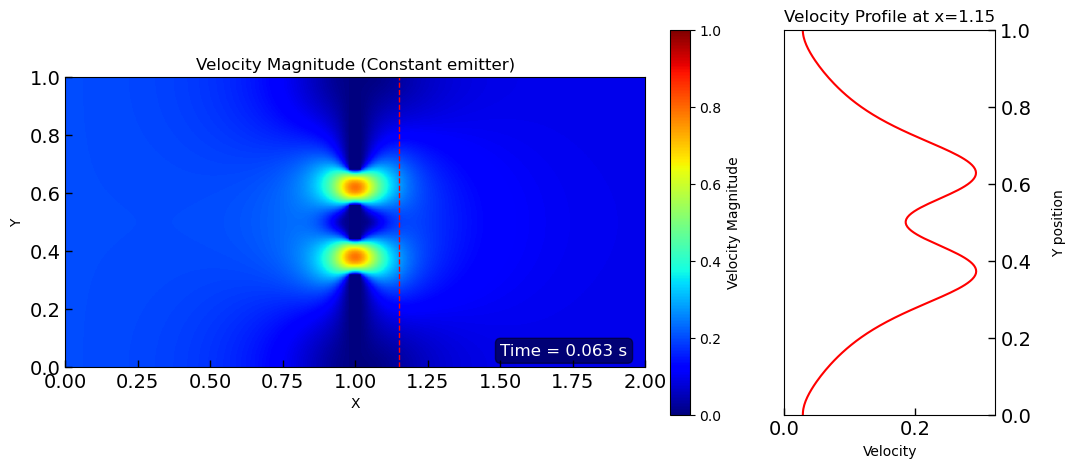

In [4]:
nx, ny = 400, 200
Lx, Ly = 2.0, 1.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
nt = 500
nit = 50
nu = 0.05
dt = min(dx, dy)**2 / (4 * nu)

U0 = 1.0 

y = np.linspace(0, Ly, ny)
x = np.linspace(0, Lx, nx)
X, Y = np.meshgrid(x, y)

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))


#Double-Slit Obstacle
screen_start = int(nx * 0.49)
screen_end = int(nx * 0.51)
slit_width = 25
slit_distance = 25

mid_y = ny // 2
top_slit_center = mid_y + slit_distance // 2 + slit_width // 2
bottom_slit_center = mid_y - slit_distance // 2 - slit_width // 2
top_slit_range = (top_slit_center - slit_width // 2, top_slit_center + slit_width // 2)
bottom_slit_range = (bottom_slit_center - slit_width // 2, bottom_slit_center + slit_width // 2)

obstacle_mask = np.zeros((ny, nx), dtype=bool)
for xi in range(screen_start, screen_end):
    for yi in range(ny):
        if not (top_slit_range[0] <= yi < top_slit_range[1]) and not (bottom_slit_range[0] <= yi < bottom_slit_range[1]):
            obstacle_mask[yi, xi] = True

def apply_obstacle(u, v):
    u[obstacle_mask] = 0
    v[obstacle_mask] = 0
    return u, v


# Time step
current_time = 0.0
def step(u, v, p, b):
    global current_time
    un = u.copy()
    vn = v.copy()

    b[1:-1, 1:-1] = (1 / dt) * (
        (un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx) +
        (vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy)
    ) - (
        ((un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx))**2 +
        2 * ((un[2:, 1:-1] - un[0:-2, 1:-1]) / (2 * dy) *
             (vn[1:-1, 2:] - vn[1:-1, 0:-2]) / (2 * dx)) +
        ((vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy))**2
    )

    for _ in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) -
                         b[1:-1, 1:-1] * dx**2 * dy**2) / (2 * (dx**2 + dy**2))
        p[:, -1] = p[:, -2]
        p[:, 0] = p[:, 1]
        p[0, :] = p[1, :]
        p[-1, :] = p[-2, :]

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))

    u[:, 0] = U0*0.2  # Const. emmiter at x=0

    v[:, 0] = 0

    #Boundary condition
    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]
    u[0, :] = u[1, :]
    u[-1, :] = u[-2, :]
    v[0, :] = 0
    v[-1, :] = 0

    u, v = apply_obstacle(u, v)
    current_time += dt
    return u, v, p, b


#Animation
vmin, vmax = 0, 1.
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})
ax1, ax2 = axes
ax1.tick_params(direction='in', length=5, width=1, labelsize=14)
ax2.tick_params(direction='in', length=5, width=1, labelsize=14, labelright=True, right=True)

cmap = plt.cm.get_cmap('jet', 256)
vel_mag = np.sqrt(u**2 + v**2)
cax1 = ax1.imshow(vel_mag, extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap,
                  vmin=vmin, vmax=vmax, aspect='equal', animated=True)
ax1.set_title("Velocity Magnitude (Constant emitter)")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
cbar = fig.colorbar(cax1, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label("Velocity Magnitude")

ax1.axvline(x=1.15, color='red', linestyle='--', lw=1)

ax2.set_title("Velocity Profile at x=1.15")
ax2.set_ylabel("Y position", labelpad=15)
ax2.set_xlabel("Velocity")
line2, = ax2.plot(np.zeros_like(y), y, color='red')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

time_text = ax1.text(0.97 * Lx, 0.03 * Ly, '', color='white', fontsize=12,
                     ha='right', va='bottom', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))


def animate(i):
    global u, v, p, b
    u, v, p, b = step(u, v, p, b)

    vel_mag = np.sqrt(u**2 + v**2)
    cax1.set_array(vel_mag)

    x_idx = int(1.15 / Lx * (nx - 1))
    profile_mag = np.sqrt(u[:, x_idx]**2 + v[:, x_idx]**2)
    line2.set_xdata(profile_mag)
    ax2.set_xlim(0, max(0.25, np.max(profile_mag) * 1.1))
    ax2.set_ylim(0,1)
    
    time_text.set_text(f"Time = {current_time:.3f} s")
    return cax1, line2, time_text

anim = animation.FuncAnimation(fig, animate, frames=500, interval=100, blit=False)
anim.save("double_slit_const_emitter.gif", writer="pillow", dpi=150)
plt.show()


C:\Users\vkuzniet\AppData\Local\Temp\ipykernel_46888\2312991426.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 256)


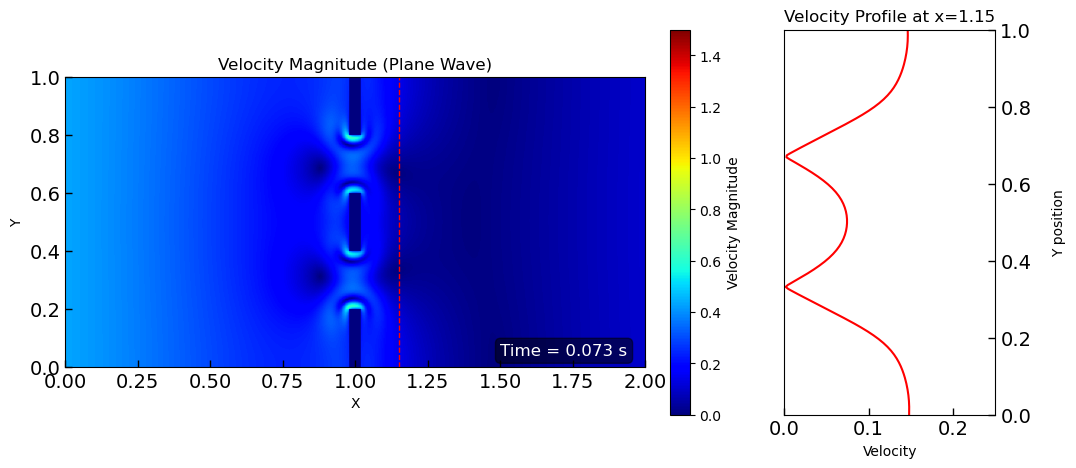

In [5]:
nx, ny = 400, 200
Lx, Ly = 2.0, 1.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
nt = 500
nit = 50
nu = 0.03
dt = min(dx, dy)**2 / (4 * nu)

U0 = 0.5  #Amplitude
freq = 16  #Frequency
omega = 2 * np.pi * freq

y = np.linspace(0, Ly, ny)
x = np.linspace(0, Lx, nx)
X, Y = np.meshgrid(x, y)

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

#Double-Slit Obstacle
screen_start = int(nx * 0.49)
screen_end = int(nx * 0.51)
slit_width = 40
slit_distance = 40

mid_y = ny // 2
top_slit_center = mid_y + slit_distance // 2 + slit_width // 2
bottom_slit_center = mid_y - slit_distance // 2 - slit_width // 2
top_slit_range = (top_slit_center - slit_width // 2, top_slit_center + slit_width // 2)
bottom_slit_range = (bottom_slit_center - slit_width // 2, bottom_slit_center + slit_width // 2)

obstacle_mask = np.zeros((ny, nx), dtype=bool)
for xi in range(screen_start, screen_end):
    for yi in range(ny):
        if not (top_slit_range[0] <= yi < top_slit_range[1]) and not (bottom_slit_range[0] <= yi < bottom_slit_range[1]):
            obstacle_mask[yi, xi] = True

def apply_obstacle(u, v):
    u[obstacle_mask] = 0
    v[obstacle_mask] = 0
    return u, v


# Time step
current_time = 0.0
def step(u, v, p, b):
    global current_time
    un = u.copy()
    vn = v.copy()

    b[1:-1, 1:-1] = (1 / dt) * (
        (un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx) +
        (vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy)
    ) - (
        ((un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx))**2 +
        2 * ((un[2:, 1:-1] - un[0:-2, 1:-1]) / (2 * dy) *
             (vn[1:-1, 2:] - vn[1:-1, 0:-2]) / (2 * dx)) +
        ((vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy))**2
    )

    for _ in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) -
                         b[1:-1, 1:-1] * dx**2 * dy**2) / (2 * (dx**2 + dy**2))
        p[:, -1] = p[:, -2]
        p[:, 0] = p[:, 1]
        p[0, :] = p[1, :]
        p[-1, :] = p[-2, :]

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))

    # Plane wave
    inflow = U0 * np.sin(omega * current_time) * np.ones_like(y)
    u[:, 0] = inflow
    v[:, 0] = 0

    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]
    u[0, :] = u[1, :]
    u[-1, :] = u[-2, :]
    v[0, :] = 0
    v[-1, :] = 0

    u, v = apply_obstacle(u, v)
    current_time += dt
    return u, v, p, b


#Animation
vmin, vmax = 0, 1.5
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})
ax1, ax2 = axes
ax1.tick_params(direction='in', length=5, width=1, labelsize=14)
ax2.tick_params(direction='in', length=5, width=1, labelsize=14, labelright=True, right=True)

cmap = plt.cm.get_cmap('jet', 256)
vel_mag = np.sqrt(u**2 + v**2)
cax1 = ax1.imshow(vel_mag, extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap,
                  vmin=vmin, vmax=vmax, aspect='equal', animated=True)
ax1.set_title("Velocity Magnitude (Plane Wave)")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
cbar = fig.colorbar(cax1, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label("Velocity Magnitude")

ax1.axvline(x=1.15, color='red', linestyle='--', lw=1)

ax2.set_title("Velocity Profile at x=1.15")
ax2.set_ylabel("Y position", labelpad=15)
ax2.set_xlabel("Velocity")
line2, = ax2.plot(np.zeros_like(y), y, color='red')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

time_text = ax1.text(0.97 * Lx, 0.03 * Ly, '', color='white', fontsize=12,
                     ha='right', va='bottom', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))

def animate(i):
    global u, v, p, b
    u, v, p, b = step(u, v, p, b)

    vel_mag = np.sqrt(u**2 + v**2)
    cax1.set_array(vel_mag)

    x_idx = int(1.15 / Lx * (nx - 1))
    profile_mag = np.sqrt(u[:, x_idx]**2 + v[:, x_idx]**2)
    line2.set_xdata(profile_mag)
    ax2.set_xlim(0, max(0.25, np.max(profile_mag) * 1.1))
    ax2.set_ylim(0, 1)
    
    time_text.set_text(f"Time = {current_time:.3f} s")
    return cax1, line2, time_text

anim = animation.FuncAnimation(fig, animate, frames=350, interval=100, blit=False)
anim.save("double_slit_plane_wave.gif", writer="pillow", dpi=150)
plt.show()


C:\Users\vkuzniet\AppData\Local\Temp\ipykernel_46888\234652668.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 256)


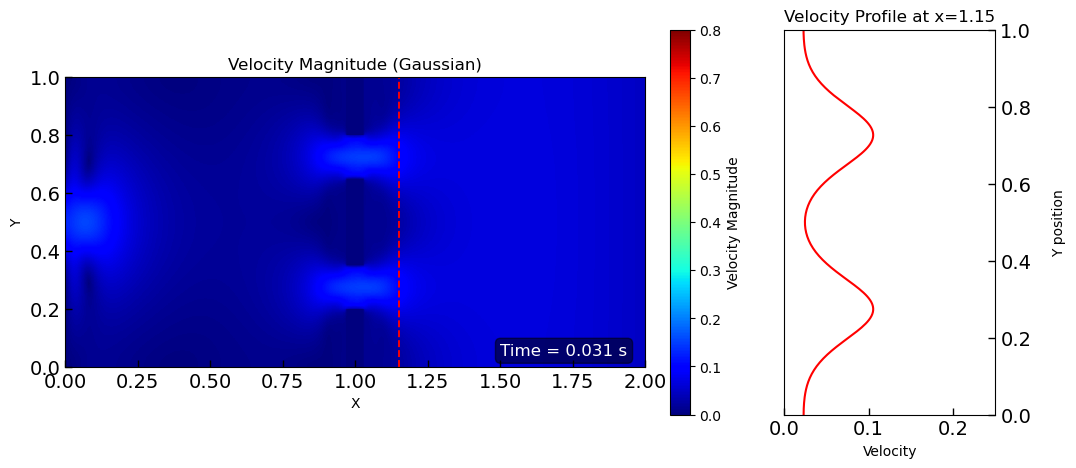

In [6]:
nx, ny = 400, 200
Lx, Ly = 2.0, 1.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
nt = 500
nit = 50
nu = 0.07
dt = min(dx, dy)**2 / (4 * nu)

U0 = 1
sigma = 0.1
y = np.linspace(0, Ly, ny)
y_center = Ly / 2
t0 = 0.001
sigma_t = 0.015
current_time = 0.0

x = np.linspace(0, Lx, nx)
X, Y = np.meshgrid(x, y)

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

#Double-Slit Obstacle
screen_start = int(nx * 0.485)
screen_end = int(nx * 0.515)
slit_width = 30
slit_distance = 60

mid_y = ny // 2
top_slit_center = mid_y + slit_distance // 2 + slit_width // 2
bottom_slit_center = mid_y - slit_distance // 2 - slit_width // 2
top_slit_range = (top_slit_center - slit_width // 2, top_slit_center + slit_width // 2)
bottom_slit_range = (bottom_slit_center - slit_width // 2, bottom_slit_center + slit_width // 2)

obstacle_mask = np.zeros((ny, nx), dtype=bool)
for xi in range(screen_start, screen_end):
    for yi in range(ny):
        if not (top_slit_range[0] <= yi < top_slit_range[1]) and not (bottom_slit_range[0] <= yi < bottom_slit_range[1]):
            obstacle_mask[yi, xi] = True

def apply_obstacle(u, v):
    u[obstacle_mask] = 0
    v[obstacle_mask] = 0
    return u, v

#Time step
def step(u, v, p, b):
    global current_time
    un = u.copy()
    vn = v.copy()

    b[1:-1, 1:-1] = (1 / dt) * (
        (un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx) +
        (vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy)
    ) - (
        ((un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx))**2 +
        2 * ((un[2:, 1:-1] - un[0:-2, 1:-1]) / (2 * dy) *
             (vn[1:-1, 2:] - vn[1:-1, 0:-2]) / (2 * dx)) +
        ((vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy))**2
    )

    for _ in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) -
                         b[1:-1, 1:-1] * dx**2 * dy**2) / (2 * (dx**2 + dy**2))
        p[:, -1] = p[:, -2]
        p[:, 0] = p[:, 1]
        p[0, :] = p[1, :]
        p[-1, :] = p[-2, :]

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))

    inflow = U0 * np.exp(-((y - y_center)**2) / (2 * sigma**2)) * np.exp(-((current_time - t0)**2) / (2 * sigma_t**2))
    u[:, 0] = inflow
    v[:, 0] = 0

    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]
    u[0, :] = u[1, :]
    u[-1, :] = u[-2, :]
    v[0, :] = 0
    v[-1, :] = 0

    u, v = apply_obstacle(u, v)
    current_time += dt
    return u, v, p, b

#Animation
vmin, vmax = 0, 0.8
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})
ax1, ax2 = axes
ax1.tick_params(direction='in', length=5, width=1, labelsize=14)
ax2.tick_params(direction='in', length=5, width=1, labelsize=14, labelright=True, right=True)

cmap = plt.cm.get_cmap('jet', 256)
vel_mag = np.sqrt(u**2 + v**2)
cax1 = ax1.imshow(vel_mag, extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap,
                  vmin=vmin, vmax=vmax, aspect='equal', animated=True)
ax1.set_title("Velocity Magnitude (Gaussian)")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
cbar = fig.colorbar(cax1, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label("Velocity Magnitude")

ax1.axvline(x=1.15, color='red', linestyle='--', lw=1.35)

ax2.set_title("Velocity Profile at x=1.15")
ax2.set_ylabel("Y position", labelpad=15)
ax2.set_xlabel("Velocity")
line2, = ax2.plot(np.zeros_like(y), y, color='red')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

time_text = ax1.text(0.97 * Lx, 0.03 * Ly, '', color='white', fontsize=12,
                     ha='right', va='bottom', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))


def animate(i):
    global u, v, p, b
    u, v, p, b = step(u, v, p, b)

    vel_mag = np.sqrt(u**2 + v**2)
    cax1.set_array(vel_mag)

    x_idx = int(1.15 / Lx * (nx - 1))
    profile_mag = np.sqrt(u[:, x_idx]**2 + v[:, x_idx]**2)
    line2.set_xdata(profile_mag)
    ax2.set_xlim(0, max(0.25, np.max(profile_mag) * 1.1))
    ax2.set_ylim(0, 1)
    time_text.set_text(f"Time = {current_time:.3f} s")
    return cax1, line2, time_text


anim = animation.FuncAnimation(fig, animate, frames=350, interval=100, blit=False)
anim.save("double_slit_profile.gif", writer="pillow", dpi=150)
plt.show()


C:\Users\vkuzniet\AppData\Local\Temp\ipykernel_35172\2029134874.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 256)


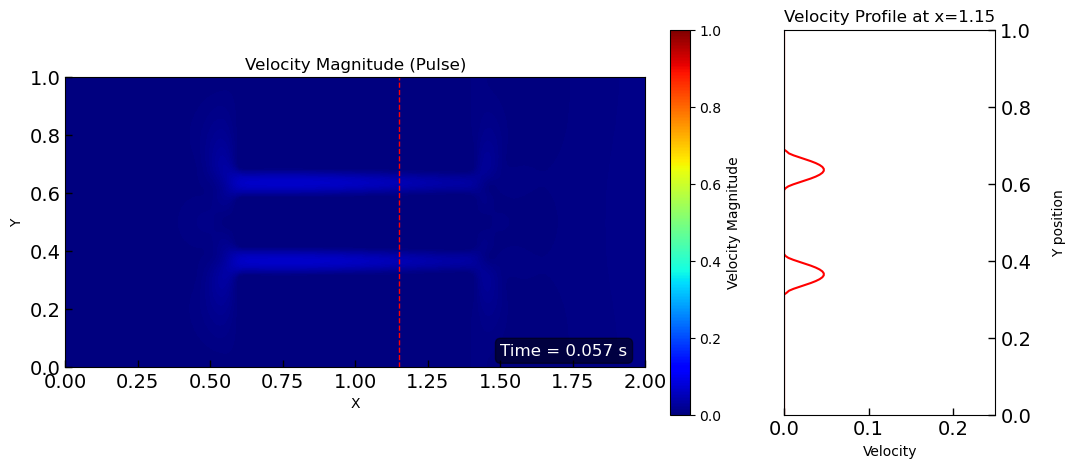

In [6]:
#Simulation Parameters
nx, ny = 400, 200
Lx, Ly = 2.0, 1.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
nt = 500
nit = 50
nu = 0.05
dt = min(dx, dy)**2 / (4 * nu)

U0 = 1.0  #Amplitude 

y = np.linspace(0, Ly, ny)
x = np.linspace(0, Lx, nx)
X, Y = np.meshgrid(x, y)

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

#Double-Slit Obstacle
screen_start = int(nx * 0.3)  
screen_end = int(nx * 0.7)
slit_width = 20
slit_distance = 35

mid_y = ny // 2
top_slit_center = mid_y + slit_distance // 2 + slit_width // 2
bottom_slit_center = mid_y - slit_distance // 2 - slit_width // 2
top_slit_range = (top_slit_center - slit_width // 2, top_slit_center + slit_width // 2)
bottom_slit_range = (bottom_slit_center - slit_width // 2, bottom_slit_center + slit_width // 2)

obstacle_mask = np.zeros((ny, nx), dtype=bool)
for xi in range(screen_start, screen_end):
    for yi in range(ny):
        if not (top_slit_range[0] <= yi < top_slit_range[1]) and not (bottom_slit_range[0] <= yi < bottom_slit_range[1]):
            obstacle_mask[yi, xi] = True

def apply_obstacle(u, v):
    u[obstacle_mask] = 0
    v[obstacle_mask] = 0
    return u, v

#Time step
current_time = 0.0
def step(u, v, p, b):
    global current_time
    un = u.copy()
    vn = v.copy()

    b[1:-1, 1:-1] = (1 / dt) * (
        (un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx) +
        (vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy)
    ) - (
        ((un[1:-1, 2:] - un[1:-1, 0:-2]) / (2 * dx))**2 +
        2 * ((un[2:, 1:-1] - un[0:-2, 1:-1]) / (2 * dy) *
             (vn[1:-1, 2:] - vn[1:-1, 0:-2]) / (2 * dx)) +
        ((vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2 * dy))**2
    )

    #Jacoby iterations
    for _ in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) -
                         b[1:-1, 1:-1] * dx**2 * dy**2) / (2 * (dx**2 + dy**2))
        p[:, -1] = p[:, -2]
        p[:, 0] = p[:, 1]
        p[0, :] = p[1, :]
        p[-1, :] = p[-2, :]

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))

    #Pulse
    if 0.0 <= current_time <= 18*dt:
        u[:, 0] = U0
    else:
        u[:, 0] = 0

    v[:, 0] = 0

    #Boundary conditions
    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]
    u[0, :] = u[1, :]
    u[-1, :] = u[-2, :]
    v[0, :] = 0
    v[-1, :] = 0

    u, v = apply_obstacle(u, v)
    current_time += dt
    return u, v, p, b

#Animation
vmin, vmax = 0, 1.
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})
ax1, ax2 = axes
ax1.tick_params(direction='in', length=5, width=1, labelsize=14)
ax2.tick_params(direction='in', length=5, width=1, labelsize=14, labelright=True, right=True)

cmap = plt.cm.get_cmap('jet', 256)
vel_mag = np.sqrt(u**2 + v**2)
cax1 = ax1.imshow(vel_mag, extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap,
                  vmin=vmin, vmax=vmax, aspect='equal', animated=True)
ax1.set_title("Velocity Magnitude (Pulse)")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
cbar = fig.colorbar(cax1, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label("Velocity Magnitude")

ax1.axvline(x=1.15, color='red', linestyle='--', lw=1)

ax2.set_title("Velocity Profile at x=1.15")
ax2.set_ylabel("Y position", labelpad=15)
ax2.set_xlabel("Velocity")
line2, = ax2.plot(np.zeros_like(y), y, color='red')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

time_text = ax1.text(0.97 * Lx, 0.03 * Ly, '', color='white', fontsize=12,
                     ha='right', va='bottom', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))


def animate(i):
    global u, v, p, b
    u, v, p, b = step(u, v, p, b)

    vel_mag = np.sqrt(u**2 + v**2)
    cax1.set_array(vel_mag)

    x_idx = int(1.15 / Lx * (nx - 1))
    profile_mag = np.sqrt(u[:, x_idx]**2 + v[:, x_idx]**2)
    line2.set_xdata(profile_mag)
    ax2.set_xlim(0, max(0.25, np.max(profile_mag) * 1.1))
    ax2.set_ylim(0,1)
    
    time_text.set_text(f"Time = {current_time:.3f} s")
    return cax1, line2, time_text


anim = animation.FuncAnimation(fig, animate, frames=450, interval=100, blit=False)
anim.save("double_slit_single_pulse_long.gif", writer="pillow", dpi=150)
plt.show()
